In [24]:
# Import all libs.
import os
import requests
from duckduckgo_search import DDGS
from pathlib import Path
import time
import dask

# Constants.
DATASET_DIR = Path(os.getcwd()) / "datasets"

In [25]:
run = None
# Wanb init.
def init_wandb():
    try:
        import wandb
        global run
        # Start a new wandb run to track this script.
        run = wandb.init(
            # Set the wandb entity where your project will be logged (generally your team name).
            entity="prinzz-personal",
            # Set the wandb project where this run will be logged.
            project="gadgets-predictor",
            # Track hyperparameters and run metadata.
            config={
                "learning_rate": 0.02,
                "architecture": "CNN",
                "dataset": "images",
                "epochs": 10,
            },
        )
    except ImportError:
        print("wandb is not installed. Skipping wandb initialization.")
    except Exception as e:
        print(f"An error occurred during wandb initialization: {e}")


In [26]:
def download_images(query, output_dir, max_results=50):
    os.makedirs(output_dir, exist_ok=True)

    # Check if output_dir already has enough images
    existing_files = [
        f for f in os.listdir(output_dir)
        if os.path.isfile(os.path.join(output_dir, f))
    ]
    if len(existing_files) >= max_results:
        print(f"Skipping '{query}': {len(existing_files)} images already present.")
        return

    ddg = DDGS()
    results = ddg.images(query, max_results=max_results)

    downloaded = len(existing_files)
    for idx, result in enumerate(results):
        if downloaded >= max_results:
            break
        image_url = result["image"]
        try:
            response = requests.get(image_url, timeout=10)
            response.raise_for_status()
            ext = image_url.split(".")[-1].split("?")[0][:4]
            filename = os.path.join(output_dir, f"{query.replace(' ', '_')}_{downloaded}.{ext}")
            with open(filename, "wb") as f:
                f.write(response.content)
            print(f"Downloaded: {filename}")
            downloaded += 1
        except Exception as e:
            print(f"Failed to download {image_url}: {e}")

In [27]:
from dask.distributed import Client
client = Client(threads_per_worker=os.cpu_count() // 2, n_workers=os.cpu_count())
gadgets = ["smartphone", "tablet", "smartwatch", "headphones", "camera"]
parallel_results = []
for gadget in gadgets:
    parallel_result= dask.delayed(download_images)(gadget, output_dir=DATASET_DIR / gadget, max_results=200)
    parallel_results.append(parallel_result)


/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40771 instead
  warnings.warn(


In [28]:
parallel_results = dask.compute(*parallel_results)
print("All downloads completed.")

Skipping 'headphones': 200 images already present.
Skipping 'tablet': 200 images already present.
Skipping 'smartphone': 200 images already present.
Skipping 'camera': 200 images already present.
Skipping 'smartwatch': 200 images already present.
All downloads completed.


In [29]:
from PIL import Image

def validate_images(directory):
  invalid_images = []
  for root, _, files in os.walk(directory):
    for file in files:
      file_path = os.path.join(root, file)
      try:
        with Image.open(file_path) as img:
          img.verify()  # Verify if the file is a valid image
      except Exception as e:
        invalid_images.append(file_path)
        print(f"Invalid image: {file_path} - {e}")
  return invalid_images

invalid_files = validate_images(DATASET_DIR)
print(f"Number of invalid images: {len(invalid_files)}")

# Remove invalid images
for invalid_file in invalid_files:
    try:
        os.remove(invalid_file)
        print(f"Removed invalid image: {invalid_file}")
    except Exception as e:
        print(f"Failed to remove {invalid_file}: {e}")

Number of invalid images: 0


In [41]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset, random_split
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from PIL import Image

def convert_to_rgb(img):
    if img.mode in ("P", "RGBA", "LA"):
        return img.convert("RGB")
    return img

In [42]:
# Step 1: Transforms
transform = transforms.Compose([
    transforms.Lambda(convert_to_rgb),  # Convert palette/transparency images
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [43]:
# Step 2: Load dataset
full_dataset = datasets.ImageFolder(DATASET_DIR, transform=transform)

# Set split ratios
total_size = len(full_dataset)
train_size = int(0.7 * total_size)        # 70% training
val_size = int(0.15 * total_size)         # 15% validation
test_size = total_size - train_size - val_size  # 15% test

# Split the dataset randomly
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # for reproducibility
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)



In [44]:
# Step 3: Use pre-trained ResNet
# For torchvision >= 0.13, use 'weights' instead of 'pretrained'
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, len(full_dataset.classes))

In [45]:
# Step 4: Train
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [46]:
# Early stopping parameters
patience = 3  # Number of epochs to wait for improvement
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

In [47]:
init_wandb()
for epoch in range(20):  # Set a high max epoch, early stopping will halt if needed
    global run
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    print(f"[Train] Epoch {epoch+1} - Loss: {running_loss:.4f}, Accuracy: {train_acc:.2f}%")

    # Validation loop
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total
    print(f"[Val]   Epoch {epoch+1} - Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")
    run.log({"train_acc": train_acc, "train_loss": running_loss,"val_acc": val_acc, "val_loss": val_loss})
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Optionally save the best model here
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            early_stop = True
            break


run.finish()

/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette i

[Train] Epoch 1 - Loss: 13.3159, Accuracy: 77.60%


/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[Val]   Epoch 1 - Loss: 3.7659, Accuracy: 82.43%


/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette i

[Train] Epoch 2 - Loss: 8.6096, Accuracy: 85.98%


/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[Val]   Epoch 2 - Loss: 3.8860, Accuracy: 81.08%


/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette i

[Train] Epoch 3 - Loss: 5.7720, Accuracy: 89.88%


/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[Val]   Epoch 3 - Loss: 3.1122, Accuracy: 83.78%


/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette i

[Train] Epoch 4 - Loss: 5.3369, Accuracy: 91.33%


/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[Val]   Epoch 4 - Loss: 3.3527, Accuracy: 81.76%


/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette i

[Train] Epoch 5 - Loss: 3.8974, Accuracy: 92.92%


/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[Val]   Epoch 5 - Loss: 2.0379, Accuracy: 89.19%


/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette i

[Train] Epoch 6 - Loss: 3.9185, Accuracy: 93.64%


/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[Val]   Epoch 6 - Loss: 6.4696, Accuracy: 71.62%


/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette i

[Train] Epoch 7 - Loss: 4.8487, Accuracy: 92.92%


/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[Val]   Epoch 7 - Loss: 2.9495, Accuracy: 79.73%


/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette i

[Train] Epoch 8 - Loss: 4.2123, Accuracy: 92.34%


/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[Val]   Epoch 8 - Loss: 2.2221, Accuracy: 85.81%
Early stopping triggered after 8 epochs.


train_acc,▁▅▆▇███▇
train_loss,█▅▂▂▁▁▂▁
val_acc,▅▅▆▅█▁▄▇
val_loss,▄▄▃▃▁█▂▁
train_acc,92.34104
train_loss,4.21231
val_acc,85.81081
val_loss,2.22209


/home/prinzz/main/my-projects/ml-learning/virtual-env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


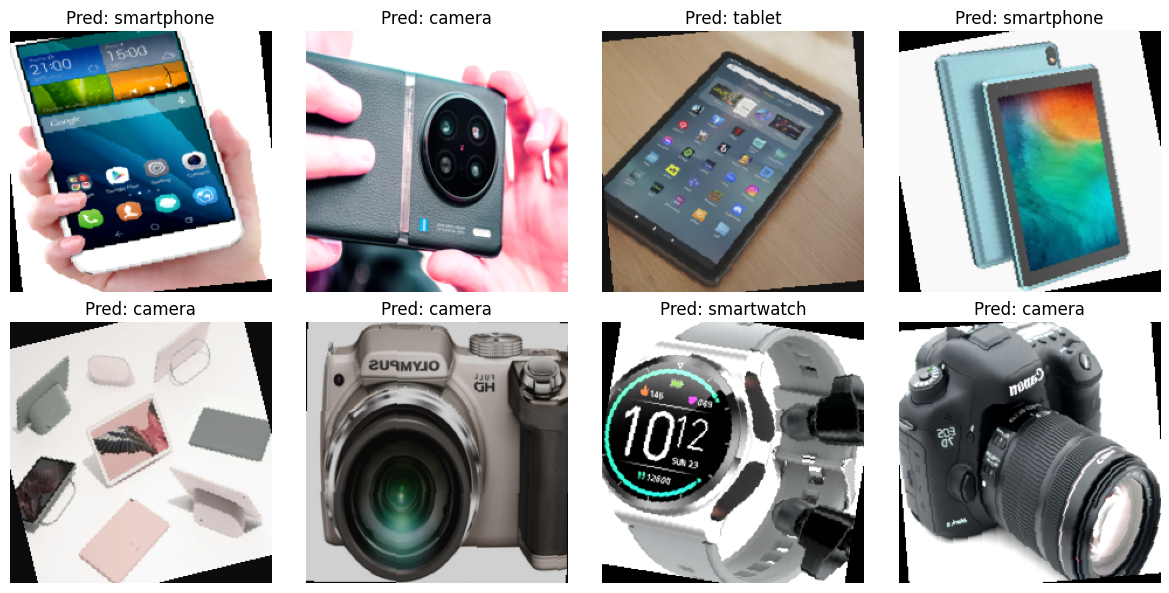

In [37]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

# Get class names from the dataset
class_names = test_loader.dataset.dataset.classes  # Note: .dataset twice due to Subset

# Get one batch
inputs, labels = next(iter(test_loader))
inputs, labels = inputs.to(device), labels.to(device)
outputs = model(inputs)
_, preds = torch.max(outputs, 1)

# Move to CPU for visualization
inputs = inputs.cpu()
preds = preds.cpu()

# Show images with predicted labels
def imshow(img_tensor):
    img = img_tensor.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.axis('off')

plt.figure(figsize=(12, 6))
for i in range(min(8, len(inputs))):
    plt.subplot(2, 4, i + 1)
    imshow(inputs[i])
    plt.title(f"Pred: {class_names[preds[i]]}")
plt.tight_layout()
plt.show()


# Exporting and Using the Trained Model for Inference
This section shows how to save your trained model and use it for inference on new images.

In [38]:
# Load the model for inference
import torch
from torchvision import models
import torch.nn as nn

# Define the model architecture (must match training)
NUM_CLASSES = len(full_dataset.classes)  # Or set manually if needed
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model.load_state_dict(torch.load('best_model.pth', map_location=torch.device('cpu')))
model.eval()
print('Model loaded and ready for inference.')

Model loaded and ready for inference.


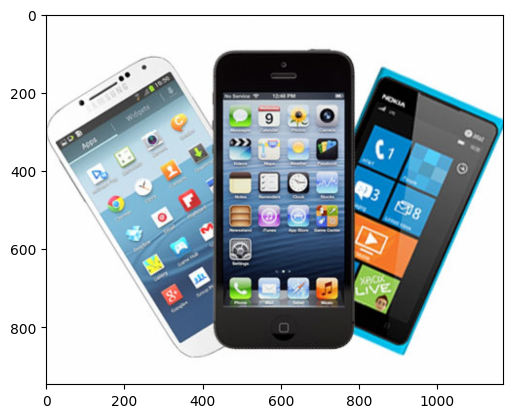

Predicted class: smartphone


In [39]:
# Inference on a new image
from PIL import Image
import torchvision.transforms as transforms

# Use the same preprocessing as validation/test
inference_transform = transforms.Compose([
    transforms.Lambda(convert_to_rgb),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load and preprocess the image
img_path = DATASET_DIR/ 'smartphone' / 'smartphone_0.jpg'  # Change to your image path

img = Image.open(img_path)
plt.imshow(img)
plt.show()
img_tensor = inference_transform(img).unsqueeze(0)

# Run inference
with torch.no_grad():
    outputs = model(img_tensor)
    _, predicted = torch.max(outputs, 1)

# Map prediction to class name
class_names = full_dataset.classes  # Or load your class names list
print(f'Predicted class: {class_names[predicted.item()]}')